# next-prev-channel

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger

In [2]:
%%time
click_data = pd.read_feather("../data/merge.feather", nthreads=4)

CPU times: user 7.21 s, sys: 7.64 s, total: 14.9 s
Wall time: 4.38 s


In [3]:
click_data.shape

(145713707, 37)

In [4]:
click_data.dtypes

app                                                uint16
channel                                            uint16
click_id                                           uint32
device                                             uint16
ip                                                 uint32
is_attributed                                       uint8
os                                                 uint16
click_time                                 datetime64[ns]
is_test                                              bool
dow                                                 uint8
hour                                                uint8
minute                                              uint8
min5                                                uint8
second                                              uint8
sin_time                                          float64
cos_time                                          float64
ip_os_device                                       uint64
ip_os_device_d

In [8]:
set(click_data[click_data.is_test == False].dow.values)

{1, 2, 3}

In [9]:
%%time
logger.info("Splitting data...")
click_data.drop(columns=["click_id", "click_time", "click_time_prev", "click_time_next"], inplace=True)
train = click_data[click_data["dow"] < 3]
valid = click_data[click_data["dow"] == 3]

del click_data
gc.collect()

[I 180430 15:51:25 <timed exec>:1] Splitting data...


CPU times: user 21.9 s, sys: 13.6 s, total: 35.5 s
Wall time: 35.4 s


In [10]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed"], inplace=True)
y_valid = valid["is_attributed"].astype("int")
valid.drop(columns=["is_attributed"], inplace=True)
gc.collect()

CPU times: user 6.95 s, sys: 6 s, total: 12.9 s
Wall time: 12.9 s


In [11]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train)
del train, y_train
gc.collect()

dvalid = xgb.DMatrix(valid, y_valid)
del valid, y_valid
gc.collect()

[I 180430 15:52:13 <timed exec>:1] Generating matrix...


CPU times: user 3min 57s, sys: 1min 9s, total: 5min 6s
Wall time: 5min 5s


[I 180430 15:57:31 <timed exec>:2] Validating...


[0]	train-auc:0.838742	valid-auc:0.83369
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.924542	valid-auc:0.913309
[10]	train-auc:0.953891	valid-auc:0.943584
[15]	train-auc:0.960903	valid-auc:0.952353
[20]	train-auc:0.966451	valid-auc:0.957807
[25]	train-auc:0.968728	valid-auc:0.959469
[30]	train-auc:0.968062	valid-auc:0.959837
[35]	train-auc:0.96904	valid-auc:0.961523
[40]	train-auc:0.969526	valid-auc:0.961957
[45]	train-auc:0.970044	valid-auc:0.962645
[50]	train-auc:0.969886	valid-auc:0.962571
[55]	train-auc:0.970702	valid-auc:0.96375
[60]	train-auc:0.97136	valid-auc:0.964598
[65]	train-auc:0.973003	valid-auc:0.965198
[70]	train-auc:0.971815	valid-auc:0.965177
[75]	train-auc:0.97215	valid-auc:0.965455
[80]	train-auc:0.972376	valid-auc:0.965703
[85]	train-auc:0.972646	valid-auc:0.966068
[90]	train-auc:0.972813	valid-auc:0.966203
[95]	train-auc:0.974514	valid-auc:0.966865
[100

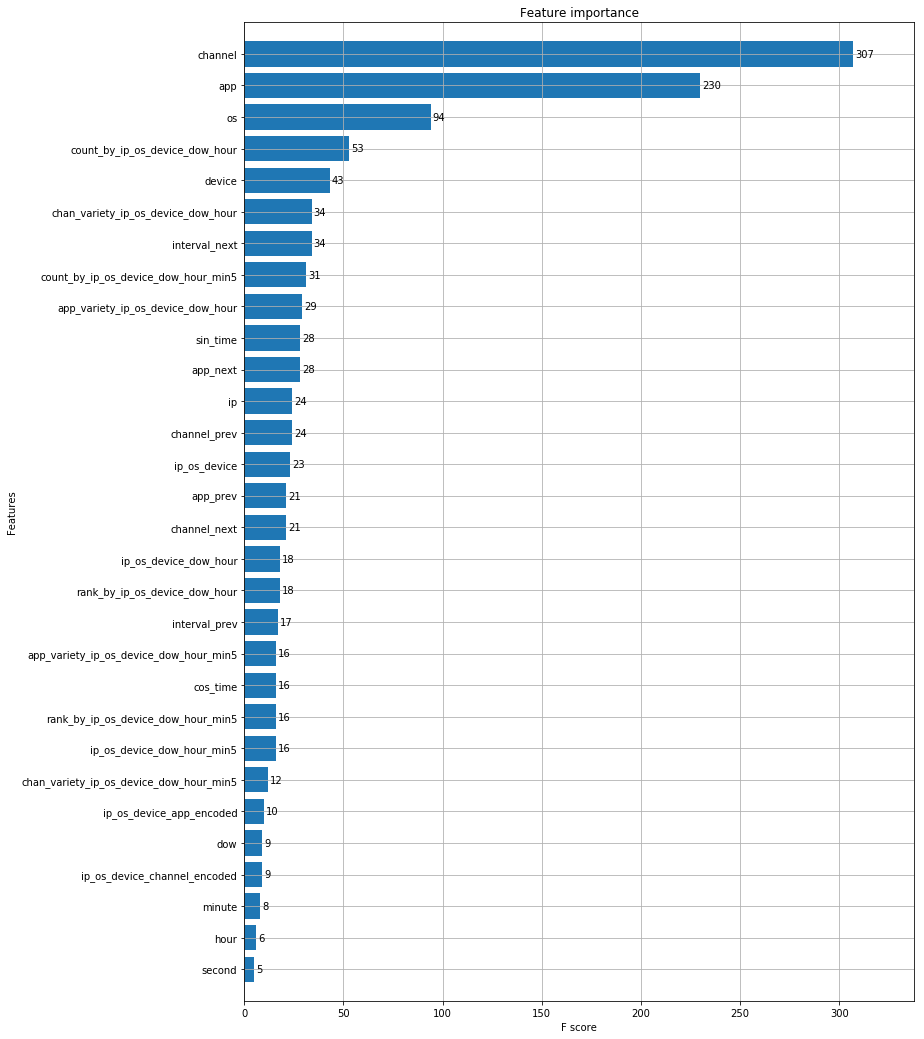

CPU times: user 4h 2min 21s, sys: 35min 44s, total: 4h 38min 6s
Wall time: 1h 23min 18s


In [12]:
%%time
n_thread = 32
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 7,
          'max_depth': 3,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 99,
          'eval_metric': 'auc',
          'nthread': n_thread,
          'random_state': 99,
          'silent': True}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  200,
                  watchlist,
                  maximize=True,
                  early_stopping_rounds=25,
                  verbose_eval=5)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

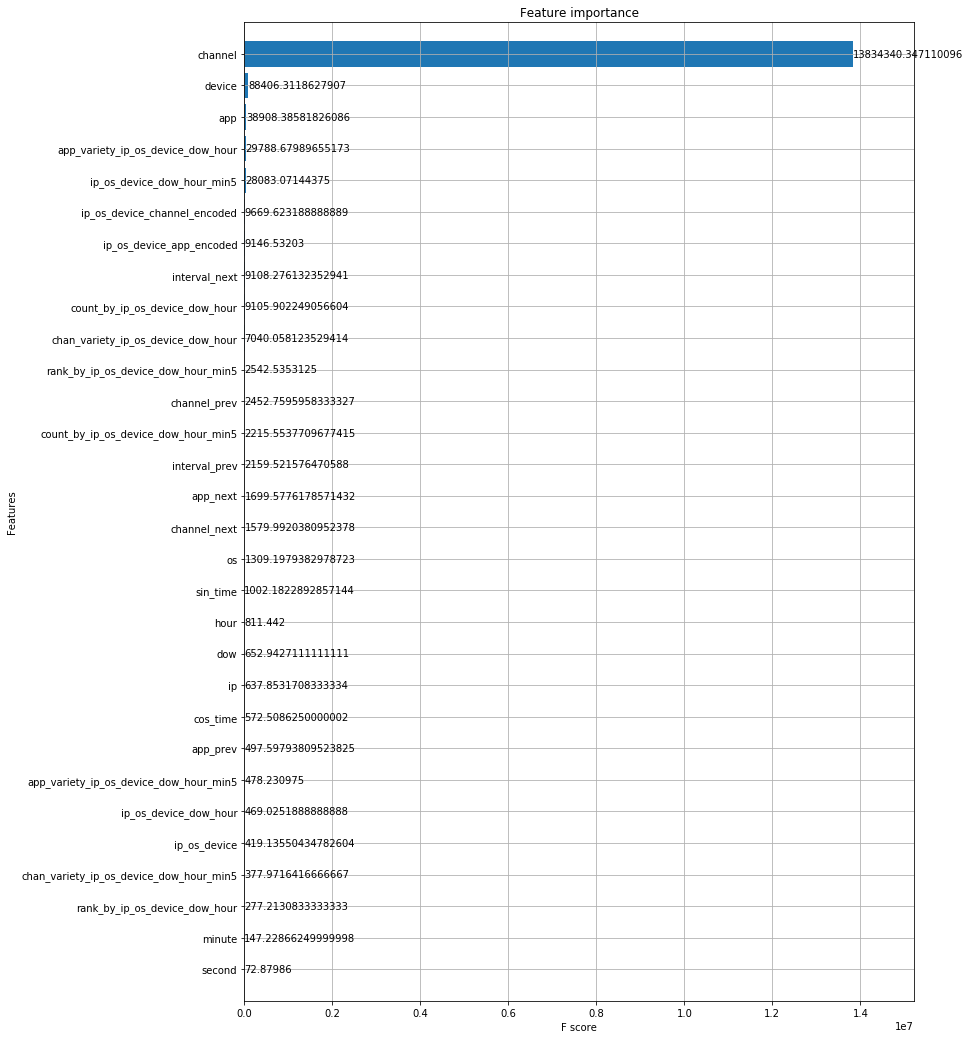

In [18]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

In [13]:
del dtrain, dvalid
gc.collect()

300

In [14]:
%%time
click_data = pd.read_feather("../data/merge.feather", nthreads=4)

CPU times: user 7.67 s, sys: 7.72 s, total: 15.4 s
Wall time: 4.49 s


In [15]:
test = click_data[click_data.is_test == True]
sub = pd.DataFrame()
sub["click_id"] = test["click_id"].astype("int")
test.drop(columns=["is_attributed", "click_id", "click_time", "click_time_prev", "click_time_next"], inplace=True)
print(sub.shape, test.shape)



(18790469, 1) (18790469, 32)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [16]:
logger.info("Generating matrix...")
dtest = xgb.DMatrix(test)
del test
gc.collect()

[I 180430 17:21:02 <ipython-input-16-79999e7ff128>:1] Generating matrix...


0

In [17]:
logger.info("Predicting...")
sub['is_attributed'] = model.predict(dtest)
sub.to_csv('xgb_sub.csv', index=False)

[I 180430 17:21:49 <ipython-input-17-f14f7549c823>:1] Predicting...


In [22]:
sub.sort_values('click_id')

,click_id,is_attributed
126923238,0,0.004469
126923241,1,0.004328
126923258,2,0.000875
126923327,3,0.001696
126923425,4,0.002252
126923452,5,0.004737
126923472,6,0.001327
126923478,7,0.008262
126923502,8,0.001803
126923501,9,0.002860
